# Project 02 CD - Stability prediction using classification methods.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from skrebate import SURF
import seaborn as sns
import plotly.express as px

c:\users\benjamin\.conda\envs\scikit-jupyter\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
seed = 99 #Setting a seed for any random task.

### Data preprocessing

#### Data loading

In [4]:
data_url = 'https://raw.githubusercontent.com/Naio/aasa-stability-prediction/master/data/processed/original/HLYZ.csv'
HLYZ = pd.read_csv(data_url)

#### Dataset

In [5]:
HLYZ

,id,stability,AASA1K0,AASA2K0,AASA3K0,AASA4K0,AASA5K0,AASA6K0,AASA7K0,AASA8K0,...,AASA1f,AASA2f,AASA3f,AASA4f,AASA5f,AASA6f,AASA7f,AASA8f,AASA9f,AASA10f
0,WT,0.0,905.996324,908.450542,907.464019,909.035486,908.902956,906.506691,906.438330,905.857810,...,3.081081,3.251701,3.486301,3.462069,3.159722,3.531469,3.274648,3.319149,3.407143,3.251799
1,A50L,-0.4,908.719637,911.144534,910.360991,911.639304,911.428040,909.164053,909.210375,908.579589,...,3.162162,3.292517,3.568493,3.503448,3.187500,3.559441,3.330986,3.347518,3.507143,3.251799
2,A50S,-1.4,907.895705,910.329473,909.484519,910.851525,910.664081,908.360074,908.371699,907.756121,...,3.121622,3.272109,3.527397,3.482759,3.173611,3.545455,3.302817,3.333333,3.457143,3.251799
3,A110S,3.4,907.882683,909.970134,909.402019,910.739155,910.895856,908.320562,908.363063,907.796193,...,3.101351,3.251701,3.506849,3.475862,3.201389,3.587413,3.295775,3.340426,3.442857,3.273381
4,A114M,0.1,908.499362,910.464431,909.846506,911.233842,911.259367,908.835094,908.639530,908.415824,...,3.182432,3.353741,3.527397,3.482759,3.305556,3.573427,3.316901,3.425532,3.450000,3.359712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,Y56F,-0.8,905.812452,908.255157,907.261886,908.854812,908.695275,906.321320,906.217265,905.645410,...,3.081081,3.251701,3.486301,3.462069,3.159722,3.531469,3.274648,3.319149,3.407143,3.251799
119,Y56G,-9.7,902.862682,905.120671,904.019170,905.956332,905.363538,903.347502,902.670810,902.237972,...,3.054054,3.224490,3.376712,3.434483,3.090278,3.503497,3.218310,3.276596,3.364286,3.223022
120,Y63F,0.3,905.800067,908.269161,907.295012,908.841846,908.714140,906.306925,906.219085,905.657410,...,3.081081,3.251701,3.486301,3.462069,3.159722,3.531469,3.274648,3.319149,3.407143,3.251799
121,Y72F,-4.0,905.805402,908.249082,907.256639,908.843532,908.691130,906.316390,906.255030,905.666077,...,3.081081,3.251701,3.486301,3.462069,3.159722,3.531469,3.274648,3.319149,3.407143,3.251799


#### Preprocessing

In [17]:
preprocessed_HLYZ = preprocess_dataset(HLYZ)
features, target = split_features_and_target(preprocessed_HLYZ)

In [ ]:
preprocessed_HLYZ

In [9]:
def preprocess_dataset(df):
    
    #Discretizing stability
    df = discretize_stability_into_zero_and_one(df)
    
    #Discarding descriptors that are highly correlated
    df = discard_highly_correlated_descriptors(df)
    
    #Feature selection
    #number_of_features = 40
    df = select_subset_of_features_ReliefF(df, 40)
    
    #Z-Score Normalization
    df = normalize_data(df)
    return df

In [10]:
def discretize_stability_into_zero_and_one(df):
    disc_stability = pd.cut(df['stability'],
           bins=[np.NINF, 0, np.Inf], 
           labels=[0, 1], right=False)
    
    return df.assign(stability=disc_stability)

In [11]:
def discard_highly_correlated_descriptors(df):
    correlations = df.corr().abs()
    upper_corr = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper_corr.columns if any(upper_corr[column] > 0.99)]
    return df.drop(columns=to_drop)

In [12]:
def select_subset_of_features_ReliefF(df, n_features):
    features_importance = calculate_features_importance(df, n_features)
    selected_features = select_n_most_important_features(features_importance, n_features)
    filtered_df = filter_selected_columns(df, selected_features)
    return filtered_df

def calculate_features_importance(df, n_features):
    features, target = split_features_and_target(df)
    
    rlf = SURF(n_features_to_select=n_features)
    rlf.fit(features, target)
    
    return pd.DataFrame({'feature_name':df.iloc[:, 2:].columns, 
                         'importance': rlf.feature_importances_})

def split_features_and_target(df):
    features = df.iloc[:, 2:].to_numpy()
    target =  df.iloc[:,1].to_numpy()
    return features, target

def select_n_most_important_features(features_importance, n_features):
    return features_importance.sort_values(by='importance', ascending=False).head(n_features)['feature_name'].tolist()

def filter_selected_columns(df, columns):
    selected = ['id', 'stability']
    selected.extend(columns)
    return df[selected]

In [13]:
def normalize_data(df):
    
    #Only descriptores are normalized, so we set apart the stability and mutation name attributes from the original dataset
    mutation_stability = df.iloc[:, 0:2]
    
    #Setting apart the descriptors data
    descriptors = df.iloc[:, 2:]
                      
    #Normalizing the descriptors using Z-Score
    normalized_descriptors = pd.DataFrame(scale(descriptors), columns=descriptors.columns)
    
    #Joining stability and mutation name to the normalized descriptors
    normalized_data = mutation_stability.join(normalized_descriptors)
    
    return normalized_data

### Project goals

- Actual Stability (-):
 - FP: Model predicts that mutation increases stability but it actually reduces the stability. -> Very Bad. Waste of resources.
 - TN: Model predicts that mutation reduces stability and it does -> Very good. We avoided waste of resources.

- Actual Stability (+):
    - TP: Model predicts that mutation increases stability and does it. -> Very good.
    - FN: Model predicts that mutation reduces stability, but it actually increases stability -> Bad, but not so much.

### Evaluation

#### Resampling method

Stratified 5-Fold CV is used, so test sets have a sufficient amount of examples and original class distribution is mirrored in train and test splits.

#### Metrics

To choose an evaluation metric, there are two considerations to have in mind, the project goals and the class imbalance in data. Some metrics are more suitable for class imbalance than others.

In [20]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

## Modeling

KNN, SVM and Logistic Regression are chosen.

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

### Experiment 1: Modeling with default hyperparameters

In [2]:
#Returns test scores of cross-validation
def evaluate_model(features, target, estimator):
    
    scores = {'precision': [],
             'roc_auc': [],
             'kappa': []}
    
    validation_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    for train_index, test_index in validation_kfold.split(features, target):
            
            #Split the data between train and test sets
            train_features, test_features = features[train_index], features[test_index]
            train_target, test_target = target[train_index], target[test_index]
    
            estimator.fit(train_features,train_target)
            predictions = estimator.predict(test_features)
            
            
            scores['precision'].append(precision_score(test_target,predictions))
            scores['roc_auc'].append(roc_auc_score(test_target,predictions))
            scores['kappa'].append(cohen_kappa_score(test_target,predictions))

    return scores

In [15]:
def display_results(results):
    results = pd.DataFrame(results)
    r = results.T
    
    r.insert(loc=0, column='min', value= results.T.min(axis='columns'))
    r.insert(loc=0, column='max', value= results.T.max(axis='columns'))
    r.insert(loc=0, column='median', value=results.T.median(axis='columns'))
    r.insert(loc=0, column='mean', value= results.T.mean(axis='columns'))
    display(r)
        

##### KNN

In [21]:
knn_naive_res = evaluate_model(features, target, KNeighborsClassifier())

In [22]:
display_results(knn_naive_res)

,mean,median,max,min,0,1,2,3,4
precision,0.616667,0.666667,0.833333,0.333333,0.750000,0.833333,0.666667,0.500000,0.333333
roc_auc,0.662512,0.626050,0.829365,0.555556,0.686508,0.829365,0.615079,0.626050,0.555556
kappa,0.354227,0.278846,0.688797,0.111111,0.429224,0.688797,0.278846,0.263158,0.111111


##### Logistic Regression

In [27]:
logreg_naive_res = evaluate_model(features, target, LogisticRegression())

In [28]:
display_results(logreg_naive_res)

,mean,median,max,min,0,1,2,3,4
precision,0.492857,0.666667,0.750000,0.000000,0.750000,0.333333,0.666667,0.000000,0.714286
roc_auc,0.650140,0.686508,0.861111,0.441176,0.686508,0.531746,0.730159,0.441176,0.861111
kappa,0.302443,0.429224,0.684211,-0.148936,0.429224,0.066390,0.481328,-0.148936,0.684211


##### SVM

In [29]:
svm_naive_res = evaluate_model(features, target, svm.SVC())

In [30]:
display_results(svm_naive_res)

,mean,median,max,min,0,1,2,3,4
precision,0.880000,1.000000,1.00,0.400000,1.000000,1.000000,1.000000,0.400000,1.00
roc_auc,0.632353,0.642857,0.75,0.554622,0.571429,0.642857,0.642857,0.554622,0.75
kappa,0.328756,0.365482,0.60,0.119266,0.193548,0.365482,0.365482,0.119266,0.60


### Experiment 2: Modeling with hyperparameter optimization

Grid Search is chosen. Dataset is small, and because of that fitting, the model doesn' take too much time. For this reason, I can try an exhaustive without increasing computational cost so much.

In [23]:
#Returns a fitted Grid Search with the best hyperparameters
def optimize_hyperparameters(features, target, estimator, estimator_grid):
    # Scoring used to select best hyperparameters
    grid_search_scoring = 'precision'

    hyperparmeter_optimization_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed + 1)
    
    grid_search = GridSearchCV(estimator = estimator, 
                           param_grid = estimator_grid, 
                           cv = hyperparmeter_optimization_cv, 
                           scoring = grid_search_scoring,
                           #When n_jobs is -1, all CPUs are used to run cross-validation in parallel
                           n_jobs=-1)
    grid_search.fit(features, target)
    
    print("Selected hyperparameters: ", grid_search.best_params_)
    
    return grid_search

##### KNN

In [24]:
knn_grid = {'n_neighbors': [2,3,4,5,6,7,8,9,10], 'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}
knn_grid_search = optimize_hyperparameters(features,target, KNeighborsClassifier(), knn_grid)
knn_opt_res = evaluate_model(features, target, knn_grid_search.best_estimator_)

Selected hyperparameters:  {'metric': 'manhattan', 'n_neighbors': 6}


In [33]:
display_results(knn_opt_res)

,mean,median,max,min,0,1,2,3,4
precision,0.710000,0.750000,1.000000,0.25,0.750000,0.750000,1.000000,0.800000,0.25
roc_auc,0.668721,0.686508,0.756303,0.50,0.686508,0.686508,0.714286,0.756303,0.50
kappa,0.387462,0.429224,0.559633,0.00,0.429224,0.429224,0.519231,0.559633,0.00


##### Logistic Regression

In [34]:
logistic_reg_grid = {'C': np.logspace(-6, 6, 13)}
logreg_grid_search = optimize_hyperparameters(features,target, LogisticRegression(solver='liblinear'), logistic_reg_grid)
logreg_opt_res = evaluate_model(features, target, logreg_grid_search.best_estimator_)

Selected hyperparameters:  {'C': 0.1}


In [35]:
display_results(logreg_opt_res)

,mean,median,max,min,0,1,2,3,4
precision,0.616667,0.750000,0.833333,0.200000,0.500000,0.750000,0.800000,0.200000,0.833333
roc_auc,0.674883,0.686508,0.888889,0.453782,0.587302,0.686508,0.757937,0.453782,0.888889
kappa,0.374443,0.429224,0.777778,-0.100917,0.200913,0.429224,0.565217,-0.100917,0.777778


##### SVM

In [36]:
svm_grid = [{'C': np.logspace(-6, 6, 13), 'gamma': np.logspace(-6, 6, 13), 'kernel': ['rbf']},
           {'C': np.logspace(-6, 6, 13), 'gamma': np.logspace(-6, 6, 13), 'kernel': ['poly'], 'degree':[2,3,4]},
           {'C': np.logspace(-6, 6, 13), 'kernel': ['linear']}]
svm_grid_search = optimize_hyperparameters(features,target, svm.SVC(), svm_grid)
svm_opt_res = evaluate_model(features, target, svm_grid_search.best_estimator_)

Selected hyperparameters:  {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}


In [37]:
display_results(svm_opt_res)

,mean,median,max,min,0,1,2,3,4
precision,0.850000,1.000000,1.00,0.250000,1.000000,1.000000,1.000000,0.250000,1.00
roc_auc,0.618067,0.642857,0.75,0.483193,0.642857,0.642857,0.571429,0.483193,0.75
kappa,0.297210,0.365482,0.60,-0.038462,0.365482,0.365482,0.193548,-0.038462,0.60


### Experiment 3: Ensembles

In [38]:
from sklearn.ensemble import BaggingClassifier

##### KNN

In [39]:
knn_ens_res = evaluate_model(features, target, 
                         BaggingClassifier(knn_grid_search.best_estimator_, n_estimators = 1000, bootstrap=True))

In [40]:
display_results(knn_ens_res)

,mean,median,max,min,0,1,2,3,4
precision,0.733333,0.750000,1.000000,0.500000,0.750000,0.750000,1.000000,0.666667,0.500000
roc_auc,0.696172,0.686508,0.726891,0.666667,0.686508,0.686508,0.714286,0.726891,0.666667
kappa,0.436939,0.429224,0.519231,0.333333,0.429224,0.429224,0.519231,0.473684,0.333333


##### Logistic regression

In [41]:
logreg_ens_res = evaluate_model(features, target, 
                         BaggingClassifier(logreg_grid_search.best_estimator_, n_estimators = 1000, bootstrap=True))

In [42]:
display_results(logreg_ens_res)

,mean,median,max,min,0,1,2,3,4
precision,0.700000,0.800000,1.000000,0.200000,0.666667,1.000000,0.800000,0.200000,0.833333
roc_auc,0.671709,0.642857,0.888889,0.453782,0.615079,0.642857,0.757937,0.453782,0.888889
kappa,0.377281,0.365482,0.777778,-0.100917,0.278846,0.365482,0.565217,-0.100917,0.777778


##### SVM

In [43]:
svm_ens_res = evaluate_model(features, target, 
                         BaggingClassifier(svm_grid_search.best_estimator_, n_estimators = 1000, bootstrap=True))

In [44]:
display_results(svm_ens_res)

,mean,median,max,min,0,1,2,3,4
precision,0.866667,1.000000,1.00,0.333333,1.000000,1.000000,1.000000,0.333333,1.00
roc_auc,0.638235,0.642857,0.75,0.512605,0.642857,0.642857,0.642857,0.512605,0.75
kappa,0.345350,0.365482,0.60,0.030303,0.365482,0.365482,0.365482,0.030303,0.60


### Results visualization

In [3]:
#Generates a plot that compares classifiers and experiments.
#The 'metric' parameter should be a string in ['precision', 'roc_auc', 'kappa']
def model_comparison(title,metric='roc_auc'):
    df1 = pd.DataFrame({'method': ['knn', 'logreg', 'svm'],
     'default': [np.array(knn_naive_res[metric]).mean(), np.array(logreg_naive_res[metric]).mean(), np.array(svm_naive_res[metric]).mean()],
    'optimized': [np.array(knn_opt_res[metric]).mean(), np.array(logreg_opt_res[metric]).mean(), np.array(svm_opt_res[metric]).mean()],
    'ensemble': [np.array(knn_ens_res[metric]).mean(), np.array(logreg_ens_res[metric]).mean(), np.array(svm_ens_res[metric]).mean()]})
    df1 = df1.set_index(df1['method'])
    df1.plot.bar(figsize=(10,5), title=title)

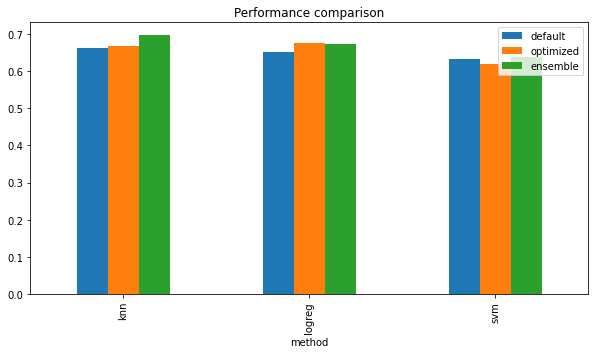

In [92]:
model_comparison(metric='roc_auc', title='Performance comparison')

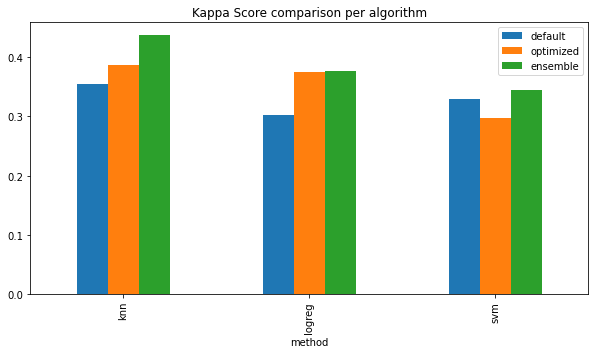

In [50]:
model_comparison(metric='kappa', title='Kappa Score comparison per algorithm')

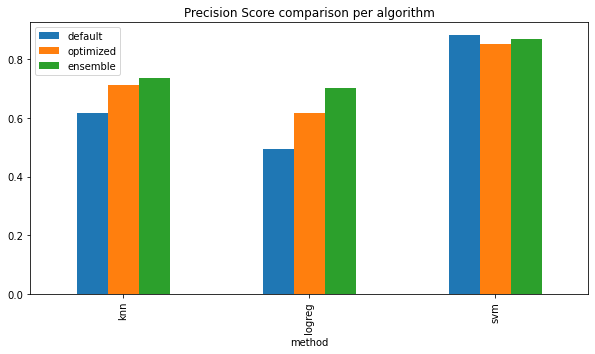

In [51]:
model_comparison(metric='precision', title='Precision Score comparison per algorithm')

In [4]:
#Generates a plot comparing the performance of classifiers in the experiment 3 using strip plots.
#The 'metric' parameter should be a string in ['precision', 'roc_auc', 'kappa']
def algorithm_comparison_ensemble_exp(metric='kappa'):
    df1 = pd.DataFrame({'knn':np.array(knn_ens_res[metric]), 
                        'logreg':np.array(logreg_ens_res[metric]),
                        'svm':np.array(svm_ens_res[metric])})
    
    sns.stripplot(x="method", y="score", 
                  data=df1.melt(value_vars=['knn','logreg', 'svm']).rename(columns={'variable':'method', 'value':'score'}))

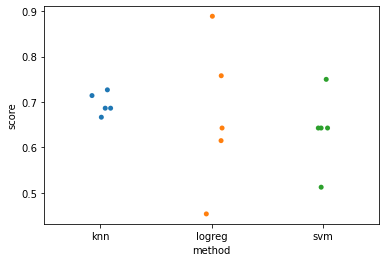

In [78]:
algorithm_comparison_ensemble_exp(metric='roc_auc')

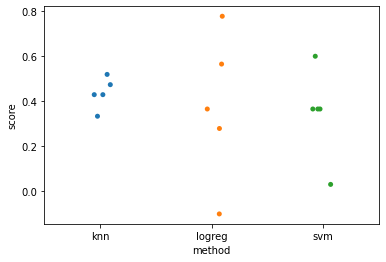

In [55]:
algorithm_comparison_ensemble_exp(metric='kappa')

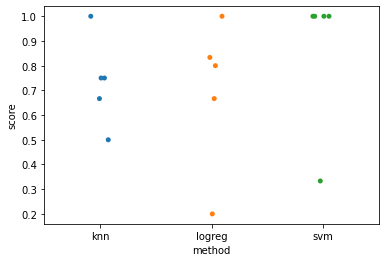

In [83]:
algorithm_comparison_ensemble_exp(metric='precision')

In [90]:
knn_scores = []
for number_of_features in np.linspace(start = 20, stop=480, num=24).astype(int):
    preprocessed_HLYZ = preprocess_dataset(HLYZ)
    features, target = split_features_and_target(preprocessed_HLYZ)
    knn_res = evaluate_model(features, target, 
                         BaggingClassifier(knn_grid_search.best_estimator_, n_estimators = 1000, bootstrap=True))
    
    knn_scores.append(np.array(knn_res['roc_auc']).mean())

In [84]:
kappa_scores = knn_scores

In [86]:
fig = px.line(y=kappa_scores, x=np.linspace(start = 20, stop=480, num=24).astype(int), 
              title='Kappa score vs Number of selected features', labels={'x':'Number of Features', 'y': 'Score'})
fig.show()

In [88]:
precision_scores = knn_scores

In [89]:
fig = px.line(y=precision_scores, x=np.linspace(start = 20, stop=480, num=24).astype(int), 
              title='Precision score vs Number of selected features', labels={'x':'Number of Features', 'y': 'Score'})
fig.show()

In [93]:
knn_roc_auc_score = knn_scores 

In [161]:
fig = px.line(y=knn_roc_auc_scores, x=np.linspace(start = 20, stop=480, num=24).astype(int), 
              title='AUC ROC score vs Number of selected features', labels={'x':'Number of Features', 'y': 'Score'})
fig.show()